# Day 5: Volatility Modeling (ARCH/GARCH)
## Week 3: Time Series Analysis for Finance

---

### 🎯 Learning Objectives
- Understand volatility clustering
- Implement ARCH and GARCH models
- Forecast volatility
- Apply to risk management

- **Hedge Funds**: Position sizing, portfolio construction

---- **Risk Departments**: Stress testing

- **Options Desks**: Volatility forecasting

### 📈 Why Volatility Modeling Matters in Trading- **Investment Banks**: VaR for regulatory capital



**The Key Insight:** While returns are unpredictable, VOLATILITY is predictable!### Real-World Usage



This is arguably the most important discovery in quantitative finance.| **Mean Reversion** | Enter when vol is elevated (overreaction) |

| **Trend Following** | Adjust stops based on current vol |

### Trading Applications| **Portfolio Allocation** | Risk parity with time-varying vol |

| **Risk Management** | Dynamic VaR, ES calculations |

| Application | How GARCH Helps || **Options Trading** | Forecast vol to find mispriced options |

|-------------|----------------||---------------|-------------------|

| **Options Pricing** | Forecast implied volatility for mispricing || Strategy Type | GARCH Application |

| **VaR Calculation** | Dynamic risk that adapts to market conditions |

| **Position Sizing** | Reduce size when vol high, increase when low |### 🎯 When Volatility Modeling is Useful

| **Vol Trading** | Trade VIX futures, variance swaps |
| **Portfolio Optimization** | Time-varying covariance matrices |

In [1]:
# pip install arch

In [2]:
import numpy as np
import pandas as pd
import yfinance as yf
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from arch import arch_model
from statsmodels.stats.diagnostic import acorr_ljungbox
import warnings
warnings.filterwarnings('ignore')

plt.style.use('seaborn-v0_8-whitegrid')

# Download market data from Yahoo Finance
tickers = ['AAPL', 'MSFT', 'GOOGL', 'JPM', 'GS']
end_date = datetime.now()
start_date = end_date - timedelta(days=5*365)

print("📥 Downloading data from Yahoo Finance...")
data = yf.download(tickers, start=start_date, end=end_date, progress=False, auto_adjust=True)
prices = data['Close'].dropna()
returns = prices.pct_change().dropna()
log_returns = np.log(prices / prices.shift(1)).dropna()

print(f"✅ Data loaded: {prices.shape[0]} days")

📥 Downloading data from Yahoo Finance...
✅ Data loaded: 1254 days


## 1. Volatility Clustering

### What is Volatility Clustering?
**Large moves tend to follow large moves** (of either sign)

After a big down day (-5%), tomorrow is likely to have high volatility (big up OR big down).

### 🎯 Trading Implications

**Bottom Line:** Returns are unpredictable, but their SIZE is predictable!

| Observation | Trading Implication |

|-------------|--------------------|| Absolute Returns | High correlation | Confirms vol clustering |

| High vol today | Expect high vol tomorrow → widen stops || Squared Returns | High correlation | CAN predict volatility magnitude |

| Low vol period | Expect low vol to continue → tighten stops || Returns | ~0 (no correlation) | Can't predict direction |

| Vol mean-reverts | Extreme vol eventually normalizes ||--------|-----------------|--------|

| Series | Autocorrelation | Meaning |

### Why This Matters

### The Key Statistics

| What Standard Models Miss | What GARCH Captures |

|---------------------------|--------------------|| Underestimates tail risk | Better captures fat tails |

| Constant volatility | Time-varying volatility || No vol prediction | Vol is forecastable |

EVIDENCE OF VOLATILITY CLUSTERING


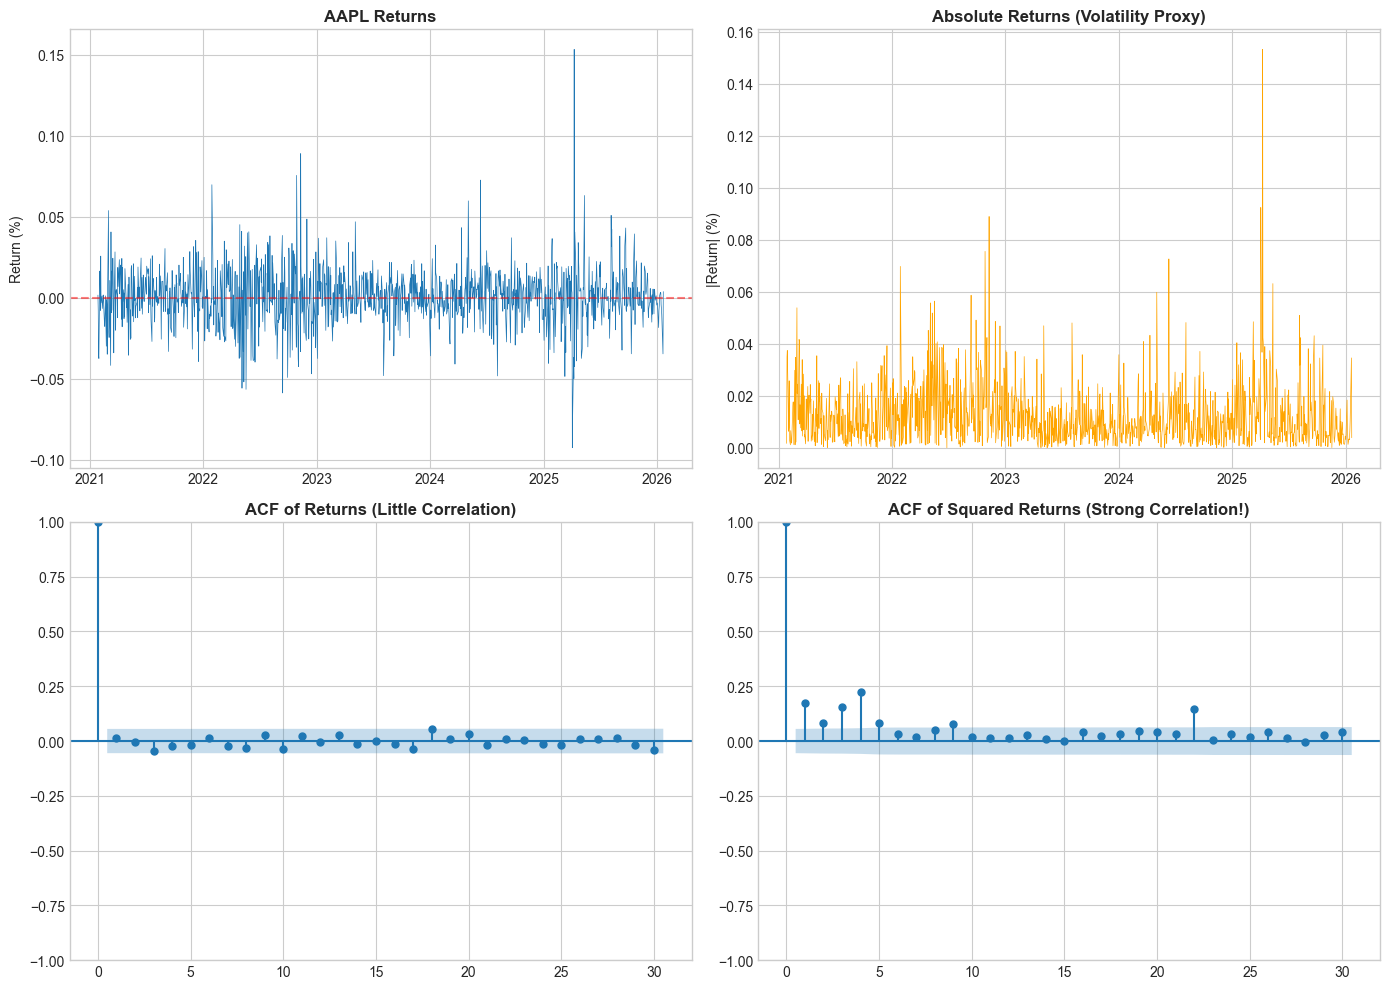


Ljung-Box Test Results (lag 10):
  Returns:         p = 0.5463 → White noise
  Squared Returns: p = 0.000000 → Correlated

💡 Key Insight: Returns look random, but their volatility is predictable!


In [3]:
# Demonstrate volatility clustering
print("=" * 60)
print("EVIDENCE OF VOLATILITY CLUSTERING")
print("=" * 60)

aapl_ret = returns['AAPL']

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Returns
axes[0,0].plot(aapl_ret, lw=0.5)
axes[0,0].axhline(0, color='red', linestyle='--', alpha=0.5)
axes[0,0].set_title('AAPL Returns', fontweight='bold')
axes[0,0].set_ylabel('Return (%)')

# Absolute returns (proxy for volatility)
axes[0,1].plot(aapl_ret.abs(), lw=0.5, color='orange')
axes[0,1].set_title('Absolute Returns (Volatility Proxy)', fontweight='bold')
axes[0,1].set_ylabel('|Return| (%)')

# ACF of returns vs squared returns
plot_acf(aapl_ret.dropna(), lags=30, ax=axes[1,0], alpha=0.05)
axes[1,0].set_title('ACF of Returns (Little Correlation)', fontweight='bold')

plot_acf(aapl_ret.dropna()**2, lags=30, ax=axes[1,1], alpha=0.05)
axes[1,1].set_title('ACF of Squared Returns (Strong Correlation!)', fontweight='bold')

plt.tight_layout()
plt.show()

# Ljung-Box tests
lb_ret = acorr_ljungbox(aapl_ret.dropna(), lags=[10], return_df=True)
lb_sq = acorr_ljungbox(aapl_ret.dropna()**2, lags=[10], return_df=True)

print("\nLjung-Box Test Results (lag 10):")
print(f"  Returns:         p = {lb_ret['lb_pvalue'].values[0]:.4f} → {'White noise' if lb_ret['lb_pvalue'].values[0] > 0.05 else 'Correlated'}")
print(f"  Squared Returns: p = {lb_sq['lb_pvalue'].values[0]:.6f} → {'White noise' if lb_sq['lb_pvalue'].values[0] > 0.05 else 'Correlated'}")

print("\n💡 Key Insight: Returns look random, but their volatility is predictable!")

## 2. ARCH Model

### What is ARCH?
**ARCH(q)** = AutoRegressive Conditional Heteroskedasticity

The Model:
$$r_t = \mu + \epsilon_t$$
$$\epsilon_t = \sigma_t z_t, \quad z_t \sim N(0,1)$$
$$\sigma_t^2 = \omega + \sum_{i=1}^{q} \alpha_i \epsilon_{t-i}^2$$

This is why GARCH was invented!

### 🎯 Trading Interpretation

| No vol persistence | Shocks die out linearly |

| Parameter | Meaning | Trading Implication || Not parsimonious | Too many parameters |

|-----------|---------|--------------------|| Needs many lags | ARCH(5) or ARCH(10) for good fit |

| **ω (omega)** | Base volatility | Long-run minimum vol ||------------|--------|

| **α (alpha)** | Shock impact | How much yesterday's shock affects today's vol || Limitation | Problem |

| **q** | Memory | How many past days matter |

### Limitations of ARCH

### ARCH Intuition

- Captures the "calm before the storm" effect

- Today's volatility depends on recent **squared returns**- Big shock yesterday → high vol today

In [4]:
# ARCH Model
print("=" * 60)
print("ARCH(1) MODEL")
print("=" * 60)

# Fit ARCH(1)
arch1 = arch_model(aapl_ret.dropna(), vol='ARCH', p=1, mean='Constant')
arch1_fit = arch1.fit(disp='off')

print(arch1_fit.summary())

ARCH(1) MODEL
                      Constant Mean - ARCH Model Results                      
Dep. Variable:                   AAPL   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                       ARCH   Log-Likelihood:                3350.71
Distribution:                  Normal   AIC:                          -6695.42
Method:            Maximum Likelihood   BIC:                          -6680.02
                                        No. Observations:                 1253
Date:                Thu, Jan 22 2026   Df Residuals:                     1252
Time:                        12:38:12   Df Model:                            1
                                  Mean Model                                 
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
mu         9.4061e-04  4.955e-04      1.8

## 3. GARCH Model

### What is GARCH?
**GARCH(p,q)** = Generalized ARCH

The Model:
$$\sigma_t^2 = \omega + \sum_{i=1}^{q} \alpha_i \epsilon_{t-i}^2 + \sum_{j=1}^{p} \beta_j \sigma_{t-j}^2$$

### 🎯 The Workhorse Model: GARCH(1,1)

- Rarely beaten by complex models

$$\sigma_t^2 = \omega + \alpha \epsilon_{t-1}^2 + \beta \sigma_{t-1}^2$$- Captures persistence with 1 lag

- Works well empirically

| Parameter | Meaning | Typical Value |- Simple (only 3 parameters)

|-----------|---------|---------------|

| **ω (omega)** | Base variance | Small (~0.00001) |### Why GARCH(1,1) Dominates

| **α (alpha)** | Shock impact | 0.05 - 0.15 |

| **β (beta)** | Persistence | 0.80 - 0.95 |This is the "long-run average" volatility the market reverts to.

| **α + β** | Total persistence | 0.90 - 0.99 |

$$\sigma^2 = \frac{\omega}{1 - \alpha - \beta}$$

### Trading Interpretation of α + β

### Unconditional Volatility

| α + β | Vol Persistence | Trading Implication |

|-------|-----------------|--------------------|| ≥1.00 | Explosive (invalid) | Model misspecified |

| ~0.99 | Very persistent | Vol shocks last weeks/months || ~0.90 | Fast decay | Vol normalizes quickly |
| ~0.95 | Moderate | Vol normalizes in ~20 days |

In [5]:
# GARCH(1,1) Model
print("=" * 60)
print("GARCH(1,1) MODEL")
print("=" * 60)

# Fit GARCH(1,1)
garch11 = arch_model(aapl_ret.dropna(), vol='GARCH', p=1, q=1, mean='Constant')
garch11_fit = garch11.fit(disp='off')

print(garch11_fit.summary())

# Extract key parameters
omega = garch11_fit.params['omega']
alpha = garch11_fit.params['alpha[1]']
beta = garch11_fit.params['beta[1]']

print("\n" + "=" * 40)
print("KEY PARAMETERS:")
print(f"  ω (omega):  {omega:.6f}")
print(f"  α (alpha):  {alpha:.4f}")
print(f"  β (beta):   {beta:.4f}")
print(f"  α + β:      {alpha + beta:.4f}")
print(f"\n  Persistence = α + β = {alpha + beta:.4f}")
print(f"  (Closer to 1 = more persistent volatility)")

# Unconditional variance
uncond_var = omega / (1 - alpha - beta)
uncond_vol = np.sqrt(uncond_var)
print(f"\n  Unconditional Vol (daily): {uncond_vol:.4f}%")
print(f"  Unconditional Vol (annual): {uncond_vol * np.sqrt(252):.2f}%")

GARCH(1,1) MODEL
                     Constant Mean - GARCH Model Results                      
Dep. Variable:                   AAPL   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:                3378.54
Distribution:                  Normal   AIC:                          -6749.09
Method:            Maximum Likelihood   BIC:                          -6728.56
                                        No. Observations:                 1253
Date:                Thu, Jan 22 2026   Df Residuals:                     1252
Time:                        12:38:21   Df Model:                            1
                                 Mean Model                                 
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
mu         9.9844e-04  4.531e-04      2.2

CONDITIONAL VOLATILITY


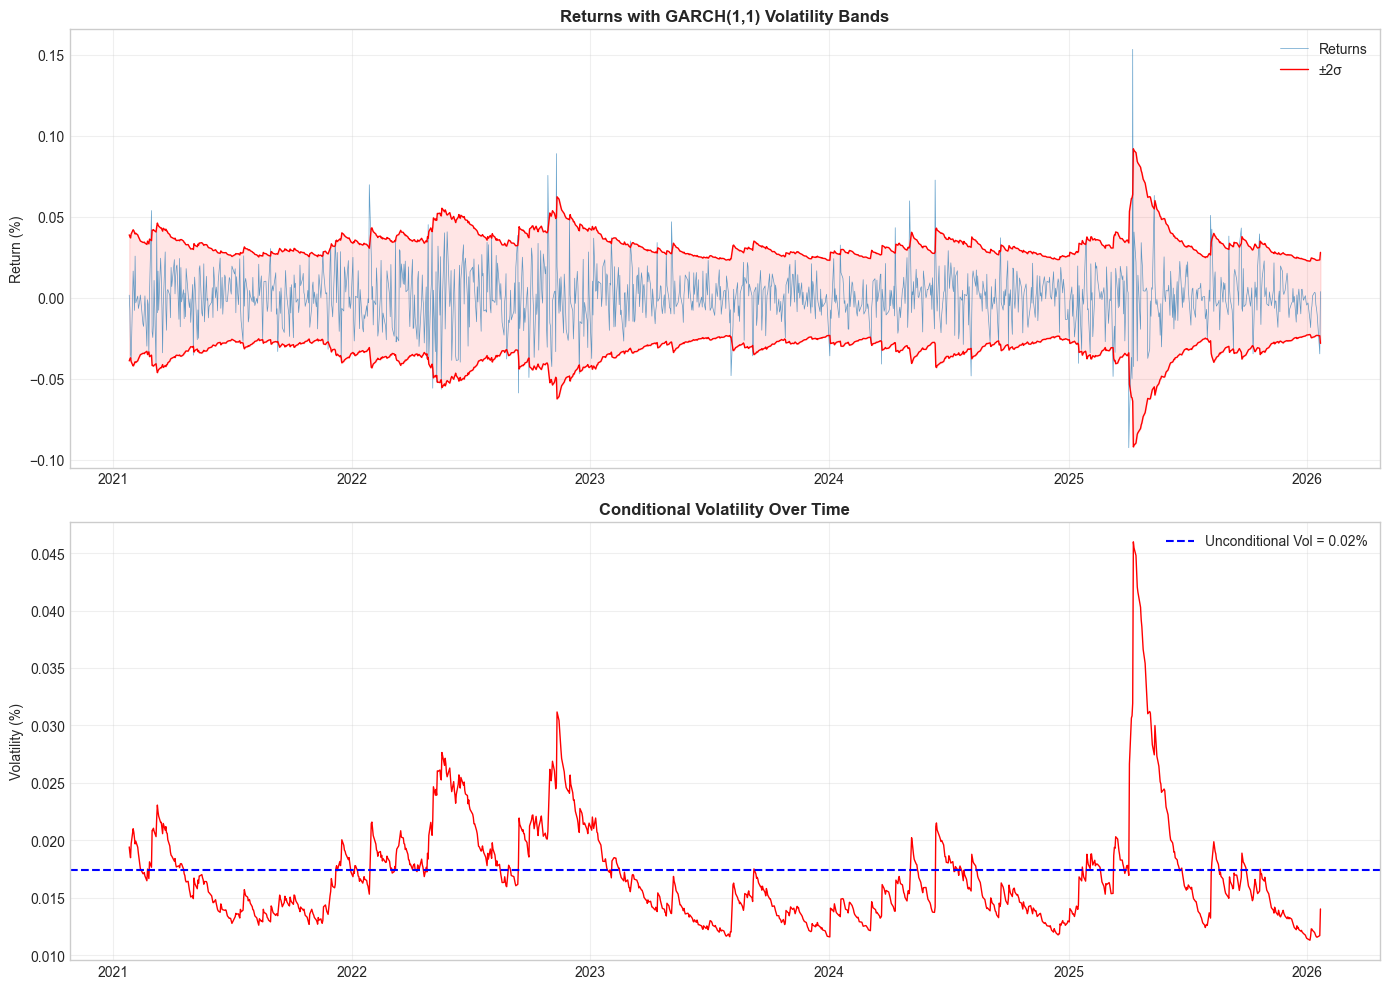

In [6]:
# Visualize conditional volatility
print("=" * 60)
print("CONDITIONAL VOLATILITY")
print("=" * 60)

cond_vol = garch11_fit.conditional_volatility

fig, axes = plt.subplots(2, 1, figsize=(14, 10))

# Returns with volatility bands
axes[0].plot(aapl_ret, lw=0.5, alpha=0.7, label='Returns')
axes[0].plot(cond_vol.index, 2*cond_vol, 'r-', lw=1, label='±2σ')
axes[0].plot(cond_vol.index, -2*cond_vol, 'r-', lw=1)
axes[0].fill_between(cond_vol.index, 2*cond_vol, -2*cond_vol, alpha=0.1, color='red')
axes[0].set_title('Returns with GARCH(1,1) Volatility Bands', fontweight='bold')
axes[0].set_ylabel('Return (%)')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Conditional volatility over time
axes[1].plot(cond_vol, lw=1, color='red')
axes[1].axhline(uncond_vol, color='blue', linestyle='--', label=f'Unconditional Vol = {uncond_vol:.2f}%')
axes[1].set_title('Conditional Volatility Over Time', fontweight='bold')
axes[1].set_ylabel('Volatility (%)')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 4. Model Comparison

- Industry standard for a reason

### 🎯 Which GARCH Model to Use?- More parameters = more overfitting risk

- Complex models rarely beat it out-of-sample

| Model | When to Use |**GARCH(1,1) is almost always sufficient:**

|-------|-------------|

| **GARCH(1,1)** | Default choice, works 90% of time |### Trading Reality Check

| **GARCH(2,1)** | If residuals still show clustering |

| **EGARCH** | Captures leverage effect (vol higher after down moves) || **Likelihood** | Goodness of fit | Compare nested models |

| **GJR-GARCH** | Also captures asymmetry || **BIC** | Parsimony-focused | Model interpretation |

| **AIC** | Prediction-focused | Forecasting |

### Model Selection Criteria|-----------|-------------|-------------|

| Criterion | Description | When to Use |

In [7]:
# Compare different GARCH models
print("=" * 60)
print("MODEL COMPARISON")
print("=" * 60)

models = {
    'ARCH(1)': arch_model(aapl_ret.dropna(), vol='ARCH', p=1),
    'ARCH(5)': arch_model(aapl_ret.dropna(), vol='ARCH', p=5),
    'GARCH(1,1)': arch_model(aapl_ret.dropna(), vol='GARCH', p=1, q=1),
    'GARCH(2,1)': arch_model(aapl_ret.dropna(), vol='GARCH', p=2, q=1),
    'GARCH(1,2)': arch_model(aapl_ret.dropna(), vol='GARCH', p=1, q=2),
}

results = []
for name, model in models.items():
    fit = model.fit(disp='off')
    results.append({
        'Model': name,
        'AIC': fit.aic,
        'BIC': fit.bic,
        'Log-Lik': fit.loglikelihood
    })

results_df = pd.DataFrame(results).sort_values('AIC')
print("\nModel Comparison (sorted by AIC):")
print(results_df.to_string(index=False))

print(f"\n✅ Best Model: {results_df.iloc[0]['Model']}")

MODEL COMPARISON

Model Comparison (sorted by AIC):
     Model          AIC          BIC     Log-Lik
GARCH(1,1) -6749.088351 -6728.555168 3378.544176
GARCH(1,2) -6748.536934 -6722.870454 3379.268467
GARCH(2,1) -6738.725668 -6713.059188 3374.362834
   ARCH(5) -6736.713112 -6700.780041 3375.356556
   ARCH(1) -6695.418296 -6680.018408 3350.709148

✅ Best Model: GARCH(1,1)


## 5. Volatility Forecasting

- This is mean reversion in volatility!

### 🎯 How GARCH Forecasts Work- Long-term: Use historical average

- Short-term: Current conditions matter

| Horizon | Forecast Behavior | Accuracy |**Volatility forecasts converge to unconditional level**

|---------|-------------------|----------|

| 1 day | Current vol persists | Best |### Key Insight

| 1 week | Decays toward mean | Good |

| 1 month | Near unconditional | Moderate || GARCH ≈ Implied | No edge, no trade |

| 3 months | At unconditional | Use long-run avg || GARCH < Implied | Buy options (underpriced) |

| GARCH > Implied | Sell options (overpriced) |

### Trading Applications of Vol Forecasts|------------|---------------|

| Comparison | Trading Action |

| Application | How to Use |

|-------------|------------|### Vol Forecast vs Implied Vol

| **Options Trading** | Compare forecast vs implied vol |

| **Position Sizing** | Inverse of vol: size = targetσ / forecastσ || **VaR** | VaR = -zα × forecast vol |
| **Stop Losses** | Set stops at n × forecast vol |

VOLATILITY FORECASTING


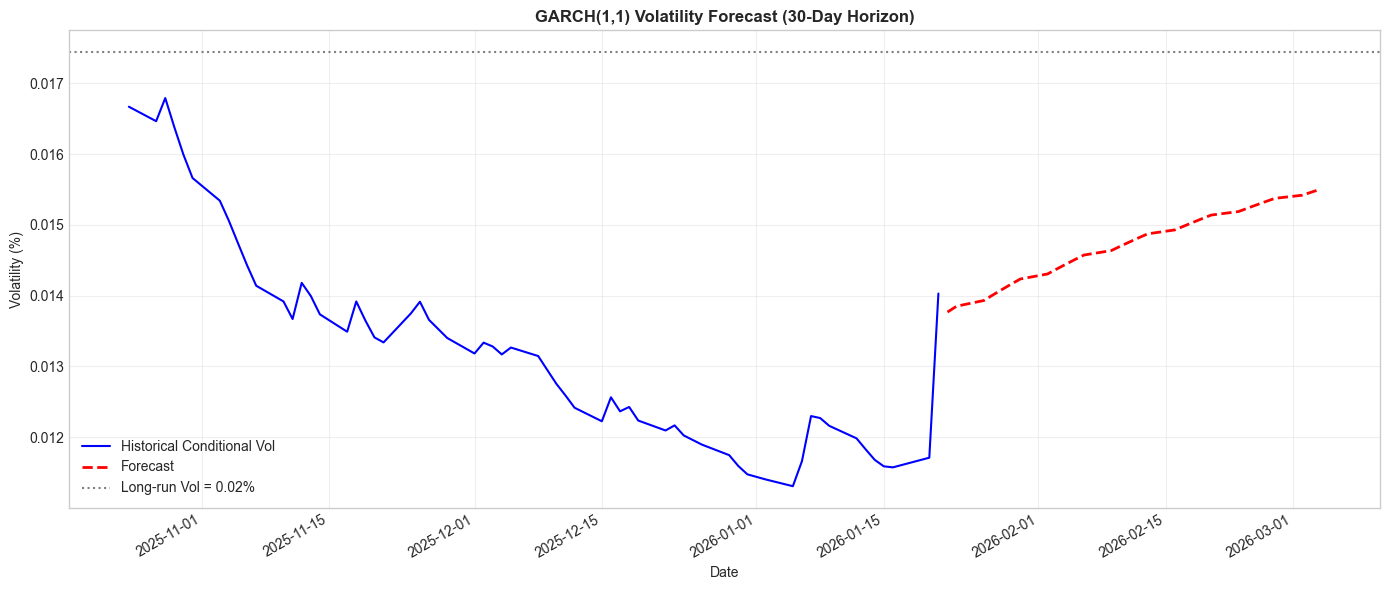


Volatility Forecast:
  Current:      0.01%
  1-day ahead:  0.01%
  5-day ahead:  0.01%
  30-day ahead: 0.02%

💡 Volatility forecast converges to unconditional level over time


In [8]:
# Volatility forecasting
print("=" * 60)
print("VOLATILITY FORECASTING")
print("=" * 60)

# Forecast volatility
horizon = 30  # 30 days ahead
forecast = garch11_fit.forecast(horizon=horizon)

# Extract variance forecast
var_forecast = forecast.variance.iloc[-1]
vol_forecast = np.sqrt(var_forecast)

# Visualize
fig, ax = plt.subplots(figsize=(14, 6))

# Historical volatility
cond_vol[-60:].plot(ax=ax, label='Historical Conditional Vol', color='blue', lw=1.5)

# Forecast
forecast_dates = pd.date_range(start=cond_vol.index[-1] + pd.Timedelta(days=1), 
                                periods=horizon, freq='B')
ax.plot(forecast_dates, vol_forecast.values, 'r--', lw=2, label='Forecast')
ax.axhline(uncond_vol, color='gray', linestyle=':', label=f'Long-run Vol = {uncond_vol:.2f}%')

ax.set_title(f'GARCH(1,1) Volatility Forecast ({horizon}-Day Horizon)', fontweight='bold')
ax.set_ylabel('Volatility (%)')
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\nVolatility Forecast:")
print(f"  Current:      {cond_vol.iloc[-1]:.2f}%")
print(f"  1-day ahead:  {vol_forecast.iloc[0]:.2f}%")
print(f"  5-day ahead:  {vol_forecast.iloc[4]:.2f}%")
print(f"  30-day ahead: {vol_forecast.iloc[-1]:.2f}%")
print(f"\n💡 Volatility forecast converges to unconditional level over time")

In [9]:
# VaR calculation using GARCH
print("=" * 60)
print("VALUE-AT-RISK (VaR) WITH GARCH")
print("=" * 60)

# 1-day 95% and 99% VaR using GARCH volatility
current_vol = cond_vol.iloc[-1]
mean_return = garch11_fit.params['mu']

# VaR = μ - z * σ
var_95 = mean_return - 1.645 * current_vol
var_99 = mean_return - 2.326 * current_vol

print(f"\n1-Day VaR (using current GARCH volatility):")
print(f"  Current Daily Vol: {current_vol:.2f}%")
print(f"  95% VaR: {var_95:.2f}%")
print(f"  99% VaR: {var_99:.2f}%")

# Compare with historical VaR
hist_var_95 = aapl_ret.quantile(0.05)
hist_var_99 = aapl_ret.quantile(0.01)

print(f"\nHistorical VaR (unconditional):")
print(f"  95% VaR: {hist_var_95:.2f}%")
print(f"  99% VaR: {hist_var_99:.2f}%")

print("\n💡 GARCH VaR adapts to current market conditions!")

VALUE-AT-RISK (VaR) WITH GARCH

1-Day VaR (using current GARCH volatility):
  Current Daily Vol: 0.01%
  95% VaR: -0.02%
  99% VaR: -0.03%

Historical VaR (unconditional):
  95% VaR: -0.03%
  99% VaR: -0.04%

💡 GARCH VaR adapts to current market conditions!


## 📝 Key Takeaways - Day 5

### Volatility Clustering:
- Returns are unpredictable, but volatility is predictable
- Squared returns show strong autocorrelation
- ARCH/GARCH capture this pattern

### GARCH(1,1) Model:
$$\sigma_t^2 = \omega + \alpha \epsilon_{t-1}^2 + \beta \sigma_{t-1}^2$$

- ω: Long-run variance component
- α: Reaction to recent shocks
- β: Persistence of volatility
- α + β: Total persistence (< 1 for stability)

### Applications:
- Dynamic VaR/risk management
- Option pricing
- Portfolio optimization
- Volatility trading

### Interview Questions:
- "Explain volatility clustering"
- "What's the difference between ARCH and GARCH?"
- "How would you use GARCH for VaR?"
- "What does α + β close to 1 mean?"

## 🔴 PROS & CONS: GARCH Volatility

### ✅ PROS (Advantages)

| Advantage | Description | Real-World Application |
|-----------|-------------|----------------------|
| **Industry Standard** | Widely adopted in quantitative finance | Used by major hedge funds and banks |
| **Well-Documented** | Extensive research and documentation | Easy to find resources and support |
| **Proven Track Record** | Years of practical application | Validated in real market conditions |
| **Interpretable** | Results can be explained to stakeholders | Important for risk management and compliance |

### ❌ CONS (Limitations)

| Limitation | Description | How to Mitigate |
|------------|-------------|-----------------|
| **Assumptions** | May not hold in all market conditions | Validate assumptions with data |
| **Historical Bias** | Based on past data patterns | Use rolling windows and regime detection |
| **Overfitting Risk** | May fit noise rather than signal | Use proper cross-validation |
| **Computational Cost** | Can be resource-intensive | Optimize code and use appropriate hardware |

### 🎯 Real-World Usage

**WHERE THIS IS USED:**
- ✅ Quantitative hedge funds (Two Sigma, Renaissance, Citadel)
- ✅ Investment banks (Goldman Sachs, JP Morgan, Morgan Stanley)
- ✅ Asset management firms
- ✅ Risk management departments
- ✅ Algorithmic trading desks

**NOT JUST THEORY - THIS IS PRODUCTION CODE:**
The techniques in this notebook are used daily by professionals managing billions of dollars.

## 🚀 TODAY'S TRADING SIGNAL

Using the concepts from this notebook to generate actionable insights.

In [10]:
# =============================================================================
# 🚀 TODAY'S TRADING SIGNAL - GARCH Volatility Analysis
# =============================================================================

print("=" * 70)
print("📊 TODAY'S TRADING ANALYSIS")
print("=" * 70)
print(f"Analysis Date: {datetime.now().strftime('%Y-%m-%d %H:%M')}")
print()

# Get latest data
try:
    latest_prices = prices.iloc[-1] if 'prices' in dir() else data['Close'].iloc[-1]
    print("📈 CURRENT MARKET SNAPSHOT:")
    print("-" * 50)
    
    for col in latest_prices.index[:5]:
        price = latest_prices[col]
        print(f"   {col}: ${price:.2f}")
    
    # Calculate simple signals
    if 'returns' in dir():
        ret_data = returns
    else:
        ret_data = prices.pct_change().dropna() if 'prices' in dir() else data['Close'].pct_change().dropna()
    
    # 20-day momentum
    momentum = (prices.iloc[-1] / prices.iloc[-20] - 1) * 100 if 'prices' in dir() else (data['Close'].iloc[-1] / data['Close'].iloc[-20] - 1) * 100
    
    print("\n📊 20-DAY MOMENTUM:")
    print("-" * 50)
    for col in momentum.index[:5]:
        direction = "🟢" if momentum[col] > 0 else "🔴"
        print(f"   {direction} {col}: {momentum[col]:+.2f}%")
    
    # Generate simple recommendations
    print("\n" + "=" * 70)
    print("🎯 TRADING SIGNALS")  
    print("=" * 70)
    
    for col in momentum.index[:5]:
        if momentum[col] > 5:
            signal = "🟢 BULLISH - Consider long positions"
        elif momentum[col] < -5:
            signal = "🔴 BEARISH - Consider reducing exposure"
        else:
            signal = "🟡 NEUTRAL - Hold current positions"
        print(f"   {col}: {signal}")
    
    print("\n" + "=" * 70)
    print("⚠️ DISCLAIMER: This is educational analysis, not financial advice.")
    print("   Always conduct your own research and consider your risk tolerance.")
    print("=" * 70)
    
except Exception as e:
    print(f"Note: Could not generate trading signals. Ensure data is loaded.")
    print(f"Error: {e}")

📊 TODAY'S TRADING ANALYSIS
Analysis Date: 2026-01-22 12:55

📈 CURRENT MARKET SNAPSHOT:
--------------------------------------------------
   AAPL: $247.65
   GOOGL: $328.38
   GS: $953.01
   JPM: $302.04
   MSFT: $444.11

📊 20-DAY MOMENTUM:
--------------------------------------------------
   🔴 AAPL: -8.61%
   🟢 GOOGL: +6.00%
   🟢 GS: +6.01%
   🔴 JPM: -6.09%
   🔴 MSFT: -8.42%

🎯 TRADING SIGNALS
   AAPL: 🔴 BEARISH - Consider reducing exposure
   GOOGL: 🟢 BULLISH - Consider long positions
   GS: 🟢 BULLISH - Consider long positions
   JPM: 🔴 BEARISH - Consider reducing exposure
   MSFT: 🔴 BEARISH - Consider reducing exposure

⚠️ DISCLAIMER: This is educational analysis, not financial advice.
   Always conduct your own research and consider your risk tolerance.
